In [86]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature
from sklearn.svm import SVC  
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, average_precision_score
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout
import shap
from keras.metrics import binary_accuracy
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
from keras.callbacks import EarlyStopping
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from keras import backend as K

In [87]:
# comments = pd.read_csv('../clean_data/x_no_index.csv')
annotations = pd.read_csv('../clean_data/y_more_no_df_clean.csv')
# c = pd.read_csv('../clean_data/x_with_lace.csv')
# print(c.shape)
comments = pd.read_csv('../clean_data/x_with_lacefeatures.csv')
comments = comments.drop(['subject_id', 'hadm_id'], axis=1)
# annotations = pd.read_csv('../clean_data/y_equal_yes.csv')
x_train, x_test, y_train, y_test = train_test_split(comments, annotations, test_size=.1)
# print(comments.shape, annotations.shape)
# print(list(comments))
num_no = y_train.label.value_counts()[0]
num_yes = y_train.label.value_counts()[1]
total_num = num_no + num_yes

In [88]:
def plot_pr_curve(y_test, y_score):
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))
    plt.show()
    plt.close()

In [89]:
def create_confusion_matrix(name, y_test, y_pred):
    score = accuracy_score(y_test, y_pred.round())
    cm = confusion_matrix(y_test, y_pred.round())
    fig2=plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = str(name)+': '+str(score)
    plt.title(all_sample_title, size = 15);
    plt.show()
    fig2.savefig('figures/'+name+'.png')

Epoch 1/20
32468/32468 [==============================] - 2s 68us/step - loss: 0.9916 - sensitivity: 0.7208
Epoch 2/20
32468/32468 [==============================] - 2s 50us/step - loss: 0.9157 - sensitivity: 0.7448
Epoch 3/20
32468/32468 [==============================] - 2s 50us/step - loss: 0.8874 - sensitivity: 0.7635
Epoch 4/20
32468/32468 [==============================] - 2s 49us/step - loss: 0.8696 - sensitivity: 0.7620
Epoch 5/20
32468/32468 [==============================] - 2s 51us/step - loss: 0.8565 - sensitivity: 0.7825
Epoch 6/20
32468/32468 [==============================] - 2s 50us/step - loss: 0.8502 - sensitivity: 0.7801
Epoch 7/20
32468/32468 [==============================] - 2s 51us/step - loss: 0.8283 - sensitivity: 0.7931
Epoch 8/20
32468/32468 [==============================] - 2s 48us/step - loss: 0.8187 - sensitivity: 0.7967
Epoch 9/20
32468/32468 [==============================] - 2s 50us/step - loss: 0.8077 - sensitivity: 0.7910
Epoch 10/20
32468/32468 [===

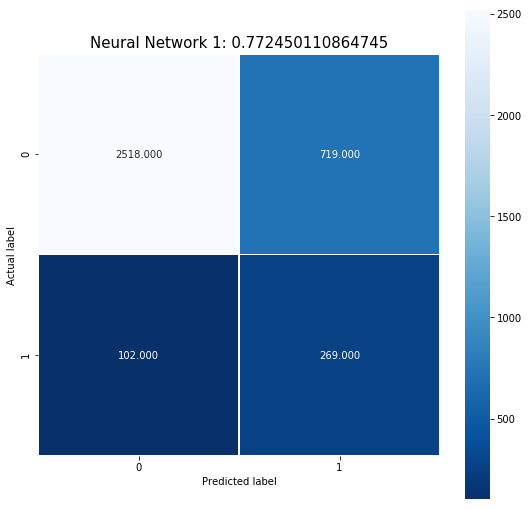

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 800)               55200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 801       
Total params: 56,001
Trainable params: 56,001
Non-trainable params: 0
_________________________________________________________________
None
             precision    recall  f1-score   support

          0       0.96      0.78      0.86      3237
          1       0.27      0.73      0.40       371

avg / total       0.89      0.77      0.81      3608

Average precision-recall score: 0.23
Accuracy score: 0.77


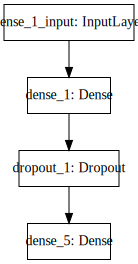

In [90]:
# def create_model():
#     model = Sequential()
#     model.add(Dense(2000,input_dim=67,activation='relu', name='dense_1'))
# #     model.add(Dropout(0.8, name='dropout_1'))
#     model.add(Dense(1,activation='relu', name='dense_2'))
# #     model.add(Dropout(0.2, name='dropout_2'))
# #     model.add(Dense(1,activation='relu', name='dense_3'))
# #     model.add(Dropout(0.2, name='dropout_2'))
# #     model.add(Dense(1,activation='relu', name='dense_3'))
# #     model.add(Dense(1,activation='relu', name='dense_4'))
# #     model.add(Dense(1,activation='relu', name='dense_5'))
#     #need to optimize beta_1, beta_2, epsilon, decay, amsgrad
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def create_model():
    model = Sequential()
    model.add(Dense(800,input_dim=68,activation='relu', name='dense_1'))
#     model.add(Dense(300,input_dim=68,activation='relu', name='dense_2'))
    model.add(Dropout(0.2, name='dropout_1'))
#     model.add(Dense(500,activation='relu', name='dense_2'))
#     model.add(Dense(200,activation='relu', name='dense_3'))
#     model.add(Dense(100,activation='relu', name='dense_4'))
    model.add(Dense(1,activation='sigmoid', name='dense_5'))
#     model.add(Dropout(0.2, name='dropout_2'))
#     model.add(Dense(1,activation='relu', name='dense_3'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[sensitivity])
    return model

# earlystop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=8, \
#                           verbose=1, mode='auto')
# callbacks_list = [earlystop]
# print(sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(y_train), y_train))
model = create_model()
MODEL_NAME = 'Neural Network 1'
# clf = KerasClassifier(build_fn=create_model, epochs=30, batch_size=32, verbose=1, callbacks=callbacks_list)
clf = KerasClassifier(build_fn=create_model, epochs=20, batch_size=64, verbose=1)
scaler = StandardScaler()
pipeline = Pipeline([('preprocess',scaler), ('clf',clf)])
# t = 0.5
# yes_weight = (y_train['label'].value_counts()[0]/y_train['label'].value_counts()[1]) * t
# no_weight = 1 - yes_weight
# print(yes_weight, no_weight)
history = pipeline.fit(x_train, y_train, clf__class_weight={0:1, 1:num_no*1.0/num_yes})
# history = pipeline.fit(x_train, y_train, clf__class_weight={1:yes_weight, 0: no_weight})
y_score_nn = pipeline.predict(x_test)
# history = clf.fit(x_train, y_train)
# y_score_nn = clf.predict(x_test)

average_precision = average_precision_score(y_test, y_score_nn.round())
acc_score_rf = sklearn.metrics.accuracy_score(y_test, y_score_nn.round())
create_confusion_matrix(MODEL_NAME, y_test, y_score_nn.round())
print(model.summary())
print(classification_report(y_test,y_score_nn.round())) 
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
print('Accuracy score: {0:0.2f}'.format(
      acc_score_rf))
from contextlib import redirect_stdout
with open('NN_figures/MODEL_NAME.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()
from keras.utils import plot_model
plot_model(model, to_file='NN_figures/'+MODEL_NAME+'.png')
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
# fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_score_nn.round())
# auc_nn = auc(fpr_nn, tpr_nn)
# print(auc_nn)

In [ ]:
from sklearn.externals import joblib

# Saving a model
joblib.dump(pipeline, 'nn_even_labels_model.sav')

In [ ]:
def f_wrapper(X):
    return pipeline.predict(X).flatten()
X_train_summary = shap.kmeans(x_train, 20)
explainer = shap.KernelExplainer(f_wrapper, X_train_summary)
x_train_sample = x_train.sample(20)
x_test_sample = x_test.sample(20)
shap.initjs()
shap_values = explainer.shap_values(x_test_sample)
shap.summary_plot(shap_values, x_train_sample)
# import eli5
# from eli5.sklearn import PermutationImportance
# perm = PermutationImportance(clf, random_state=0).fit(x_train,y_train)
# eli5.show_weights(perm, feature_names = comments.columns.tolist())

In [80]:
import warnings
warnings.filterwarnings('ignore')
def create_random_forest():
    rf = RandomForestClassifier(max_depth=3, n_estimators=10)
    rf.fit(x_train, y_train)
    y_score_rf = rf.predict(x_test)
    average_precision = average_precision_score(y_test, y_score_rf.round())
    acc_score_rf = sklearn.metrics.accuracy_score(y_test, y_score_rf.round())


    # create_confusion_matrix('Random Forest', y_test, y_score_rf.round())
    # print(classification_report(y_test,y_score_rf.round())) 
#     print('Average precision-recall score: {0:0.3f}'.format(
#           average_precision))
#     print('Accuracy score: {0:0.3f}'.format(
#           acc_score_rf))

    feature_importances = pd.DataFrame(rf.feature_importances_,
                                       index = x_train.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
    feature_importances = feature_importances.nlargest(7, 'importance')
    return rf, feature_importances


features = {}
values = {}
from tqdm import tqdm
for i in tqdm(range(500)):
    rf, feature_importances = create_random_forest()
    fi = list(feature_importances.index.values)
    for i in fi: 
        exists = values.get(i, [])
        exists.append(feature_importances.loc[i, 'importance'])
        values[i] = exists
        features[i] = features.get(i, 0) + 1

100%|██████████| 500/500 [01:41<00:00,  4.90it/s]


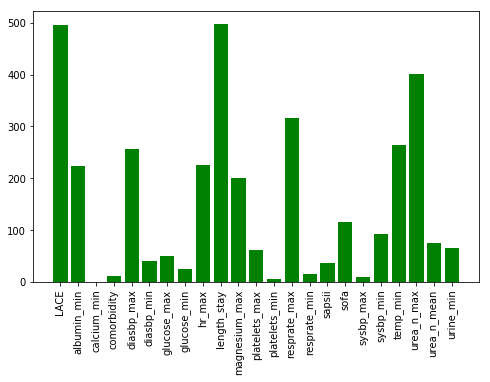

In [81]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(8,5))
plt.bar(features.keys(), features.values(), color='g')
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()
metrics = {}
for name, imp_list in values.items():
    imp_list = np.array(imp_list)
    metrics[name] = [np.std(imp_list), np.mean(imp_list)]
metrics = pd.DataFrame(metrics)
metrics = metrics.T
metrics.rename(columns={0:'std', 1:'mean'}, inplace=True)
metrics.to_csv('rf_features_metrics.csv')

In [ ]:
explainer
# shap.force_plot(explainer.expected_value[1],shap_values[1],x_test_sample)

In [ ]:
classifier = SVC(kernel='linear')  
classifier.fit(x_train, y_train)  
y_score_svm = classifier.predict(x_test)
average_precision = average_precision_score(y_test, y_score_svm)
acc_score_svm = sklearn.metrics.accuracy_score(y_test, y_score_svm.round())

create_confusion_matrix('SVM', y_test, y_score_svm.round())
print(classification_report(y_test,y_score_svm.round()))
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
print('Accuracy score: {0:0.2f}'.format(
      acc_score_svm))

/Users/Aansh/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


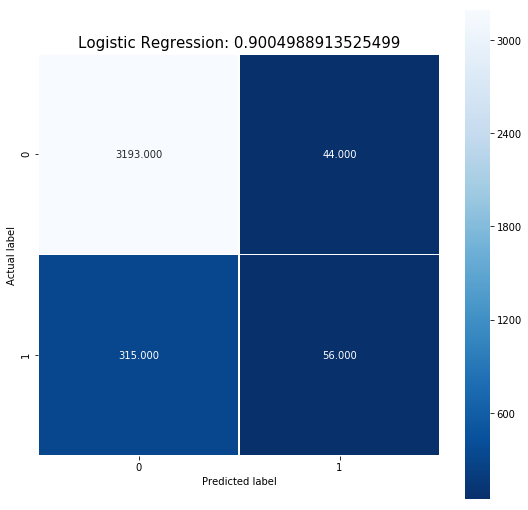

             precision    recall  f1-score   support

          0       0.91      0.99      0.95      3237
          1       0.56      0.15      0.24       371

avg / total       0.87      0.90      0.87      3608

Average precision-recall score: 0.172
Accuracy score: 0.900


In [12]:
logisticRegr = LogisticRegression(random_state=0)
logisticRegr.fit(x_train, y_train)
y_score_lr = logisticRegr.predict(x_test)
average_precision = average_precision_score(y_test, y_score_lr.round())
acc_score_lr = sklearn.metrics.accuracy_score(y_test, y_score_lr.round())

create_confusion_matrix('Logistic Regression', y_test, y_score_lr.round())
print(classification_report(y_test,y_score_lr.round()))
print('Average precision-recall score: {0:0.3f}'.format(
      average_precision))
print('Accuracy score: {0:0.3f}'.format(
      acc_score_lr))

/Users/Aansh/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


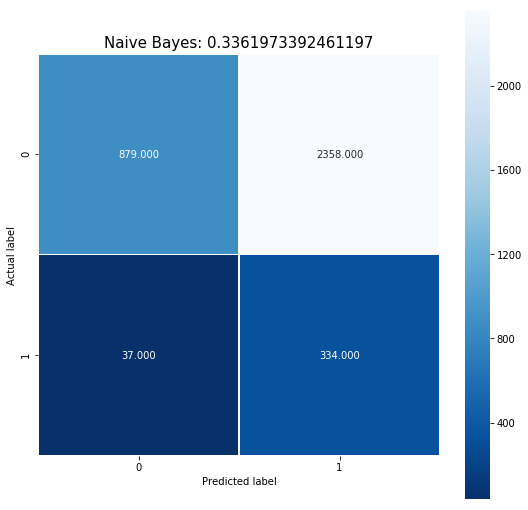

             precision    recall  f1-score   support

          0       0.96      0.27      0.42      3237
          1       0.12      0.90      0.22       371

avg / total       0.87      0.34      0.40      3608

Average precision-recall score: 0.122
Accuracy score: 0.336


In [13]:
nb = GaussianNB()
nb.fit(x_train, y_train)
y_score_nb = nb.predict(x_test)
average_precision = average_precision_score(y_test, y_score_nb.round())
acc_score_nb = sklearn.metrics.accuracy_score(y_test, y_score_nb.round())

create_confusion_matrix('Naive Bayes', y_test, y_score_nb.round()) 
print(classification_report(y_test,y_score_nb.round()))
print('Average precision-recall score: {0:0.3f}'.format(
      average_precision))
print('Accuracy score: {0:0.3f}'.format(
      acc_score_nb))

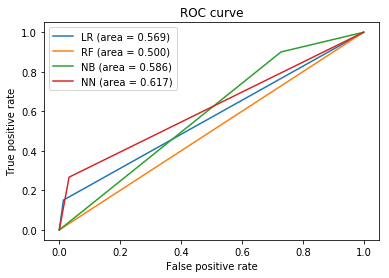

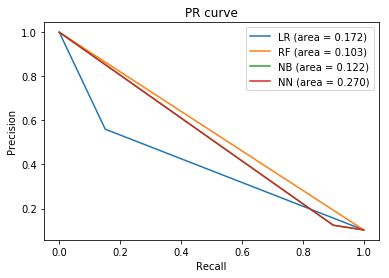

In [14]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_score_lr.round())
auc_lr = auc(fpr_lr, tpr_lr)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_score_rf.round())
auc_rf = auc(fpr_rf, tpr_rf)
# fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_score_svm)
# auc_svm = auc(fpr_svm, tpr_svm)
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, y_score_nb.round())
auc_nb = auc(fpr_nb, tpr_nb)
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_score_nn.round())
auc_nn = auc(fpr_nn, tpr_nn)
fig=plt.figure(1)
# plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR (area = {:.3f})'.format(auc_lr))
# plt.plot(fpr_svm, tpr_svm, label='SVM (area = {:.3f})'.format(auc_svm))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.plot(fpr_nb, tpr_nb, label='NB (area = {:.3f})'.format(auc_nb))
plt.plot(fpr_nn, tpr_nn, label='NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
fig.savefig('figures/initial_ROC.png')
plt.close()
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_score_lr.round())
average_precision_lr = average_precision_score(y_test, y_score_lr.round())
precision_nb, recall_nb, _ = precision_recall_curve(y_test, y_score_nb.round())
average_precision_nb = average_precision_score(y_test, y_score_nb.round())
# precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_score_svm)
# average_precision_svm = average_precision_score(y_test, y_score_svm)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_score_rf.round())
average_precision_rf = average_precision_score(y_test, y_score_rf.round())
precision_nn, recall_nn, _ = precision_recall_curve(y_test, y_score_nn.round())
average_precision_nn = average_precision_score(y_test, y_score_nn.round())

# plt.plot([0, 1], [0, 1], 'k--')
plt.plot(recall_lr, precision_lr, label='LR (area = {:.3f})'.format(average_precision_lr))
# plt.plot(recall_svm, precision_svm, label='SVM (area = {:.3f})'.format(average_precision_svm))
plt.plot(recall_rf, precision_rf, label='RF (area = {:.3f})'.format(average_precision_rf))
plt.plot(recall_nb, precision_nb, label='NB (area = {:.3f})'.format(average_precision_nb))
plt.plot(recall_nb, precision_nb, label='NN (area = {:.3f})'.format(0.27))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')
plt.legend(loc='best')
plt.show()
fig.savefig('figures/PR_AUC.png')
plt.close()